# Análise exploratória de dados espaciais - AEDE

Observações com altos valores de uma variável tendem a estar próximos de observações também com altos valores da mesma variável? Ou estão mais próximas de observações com baixos valores? Ou tudo é aleatório?

O objetivo da análise exploratória de dados espaciais (AEDE) é responder a esse tipo de questão. De forma mais geral, a questão é qual a associação entre o valor de certa variável em um lugar e os valores dessa mesma variável nos lugares vizinhos. Localidades com valores semelhantes de determinada variável tendem a estar próximas? Para isso, mede-se a autocorrelação espacial, por meio do $I$ de Moran.

Para que isso seja possível no *Python* é necessário carregamos dois tipos de arquivos:
- o *dataframe* com as informações da variável em estudo
- o *shapefile* com as informações geográficas de cada ponto do conjunto de dados

Com a junção dos dois teremos o *geodataframe* que terá as duas informações (sobre a variável em cada ponto e a localização de cada ponto).

A instalação dos pacotes demora um pouco.

In [1]:
!pip install geopandas
!pip install --upgrade pyshp
!pip install shapely
!pip install --upgrade descartes
!pip install mapclassify libpysal splot
!pip install esda
!pip install pysal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.8/322.8 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━

In [2]:
# carregar pacotes
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm
import os

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format    # pandas: para todos os números aparecerem com duas casas decimais

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# Leitura dos dados

Neste caso leremos os dados a partir de um link:

In [3]:
dados = pd.read_csv('https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/culturas-2018.csv', encoding='utf-8')

In [4]:
# nomes das variáveis
dados.columns

Index(['mun', 'municipio', 'algodao', 'arroz', 'banana', 'cafe', 'cana',
       'feijao', 'fumo', 'laranja', 'mandioca', 'milho', 'soja', 'tomate'],
      dtype='object')

In [5]:
# número de linhas e colunas do dataframe
dados.shape

(5563, 14)

In [6]:
# mostrar algumas linhas do dataframe
dados.head(3)

,mun,municipio,algodao,arroz,banana,cafe,cana,feijao,fumo,laranja,mandioca,milho,soja,tomate
0,1100015,Alta Floresta D'Oeste,0,705,1859,15356,0,2044,0,0,11320,16267,1350,500
1,1100023,Ariquemes,0,2680,2916,208,1380,4,0,12,5850,3600,16800,45
2,1100031,Cabixi,0,8820,175,113,17000,0,0,20,1680,94647,86234,0


## Ler arquivo com informações adicionais (meso, microrregiões etc.)

In [7]:
cod = pd.read_csv('https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/codigos-municipios.csv', encoding='utf8')

In [8]:
# primeiras linhas do objeto cod
cod.head()

,nome_mun,codmun6,mun,micro,nome_micro,meso,nome_meso,uf,sigla_uf,nome_uf,regiao,nome_regiao,rm
0,Alta Floresta D'Oeste,110001,1100015,11006,Cacoal,1102,Leste Rondoniense,11,RO,Rondônia,1,Norte,NaN
1,Ariquemes,110002,1100023,11003,Ariquemes,1102,Leste Rondoniense,11,RO,Rondônia,1,Norte,NaN
2,Cabixi,110003,1100031,11008,Colorado do Oeste,1102,Leste Rondoniense,11,RO,Rondônia,1,Norte,NaN
3,Cacoal,110004,1100049,11006,Cacoal,1102,Leste Rondoniense,11,RO,Rondônia,1,Norte,NaN
4,Cerejeiras,110005,1100056,11008,Colorado do Oeste,1102,Leste Rondoniense,11,RO,Rondônia,1,Norte,NaN


In [9]:
# mesclar dataframes
dados = dados.merge(cod)

In [10]:
# reorganizar colunas
dados = dados.loc[:, ['mun', 'nome_mun', 'sigla_uf', 'nome_regiao', 'nome_meso',
       'nome_micro', 'algodao', 'arroz', 'banana', 'cafe', 'cana',
       'feijao', 'fumo', 'laranja', 'mandioca', 'milho', 'soja', 'tomate']]

## Ler *shapefile* - informações de localização

In [11]:
# ler shapefile
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/br.json'
geodf = gp.read_file(link)

In [12]:
geodf.head()

,NM_MUNICIP,CD_GEOCMU,geometry
0,ALTA FLORESTA D'OESTE,1100015,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8..."
1,ARIQUEMES,1100023,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772..."
2,CABIXI,1100031,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3..."
3,CACOAL,1100049,"POLYGON ((-61.0008 -11.29737, -61.00302 -11.40..."
4,CEREJEIRAS,1100056,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0..."


Para mesclar o *shapefile* com o *dataframe* eles precisam ter uma coluna em comum. Eles têm e é a coluna com o código do município, porém, o nome dessa coluna está diferente em cada objeto. No *shapefile* ela se chama 'CD_GEOCMU' e no 'dataframe' ela se chama 'mun'. Vamos deixar as duas com o mesmo nome:

In [13]:
# mesclar shapefile com dataframe
# usando a coluna mun
geodf.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)  # mudar nome da coluna com cód. para 'mun'
geodf['mun'] = geodf.mun.astype(int)  # transformar códigos em inteiros

In [14]:
geodf.head()

,NM_MUNICIP,mun,geometry
0,ALTA FLORESTA D'OESTE,1100015,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8..."
1,ARIQUEMES,1100023,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772..."
2,CABIXI,1100031,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3..."
3,CACOAL,1100049,"POLYGON ((-61.0008 -11.29737, -61.00302 -11.40..."
4,CEREJEIRAS,1100056,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0..."


In [15]:
# unir os dois objetos em um geodataframe
br = pd.merge(geodf, dados, on='mun')  # mesclar o dataframe e o shapefile

In [16]:
br.shape

(5563, 20)

In [17]:
# ver objeto resultante (dataframe + shapefile)
# verificar se tudo deu certo
br.head()

,NM_MUNICIP,mun,geometry,nome_mun,sigla_uf,nome_regiao,nome_meso,nome_micro,algodao,arroz,banana,cafe,cana,feijao,fumo,laranja,mandioca,milho,soja,tomate
0,ALTA FLORESTA D'OESTE,1100015,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8...",Alta Floresta D'Oeste,RO,Norte,Leste Rondoniense,Cacoal,0,705,1859,15356,0,2044,0,0,11320,16267,1350,500
1,ARIQUEMES,1100023,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772...",Ariquemes,RO,Norte,Leste Rondoniense,Ariquemes,0,2680,2916,208,1380,4,0,12,5850,3600,16800,45
2,CABIXI,1100031,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3...",Cabixi,RO,Norte,Leste Rondoniense,Colorado do Oeste,0,8820,175,113,17000,0,0,20,1680,94647,86234,0
3,CACOAL,1100049,"POLYGON ((-61.0008 -11.29737, -61.00302 -11.40...",Cacoal,RO,Norte,Leste Rondoniense,Cacoal,0,90,5220,20384,1320,788,0,0,13400,3616,1710,31
4,CEREJEIRAS,1100056,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0...",Cerejeiras,RO,Norte,Leste Rondoniense,Colorado do Oeste,0,3600,79,49,3325,22,0,0,2925,100965,112620,1080


In [18]:
br.columns

Index(['NM_MUNICIP', 'mun', 'geometry', 'nome_mun', 'sigla_uf', 'nome_regiao',
       'nome_meso', 'nome_micro', 'algodao', 'arroz', 'banana', 'cafe', 'cana',
       'feijao', 'fumo', 'laranja', 'mandioca', 'milho', 'soja', 'tomate'],
      dtype='object')

In [19]:
# apagar a coluna NM_MUNICIP já que ela e nome_mun contêm a mesma informação
br = br.drop('NM_MUNICIP', axis=1)

In [20]:
br.head()

,mun,geometry,nome_mun,sigla_uf,nome_regiao,nome_meso,nome_micro,algodao,arroz,banana,cafe,cana,feijao,fumo,laranja,mandioca,milho,soja,tomate
0,1100015,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8...",Alta Floresta D'Oeste,RO,Norte,Leste Rondoniense,Cacoal,0,705,1859,15356,0,2044,0,0,11320,16267,1350,500
1,1100023,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772...",Ariquemes,RO,Norte,Leste Rondoniense,Ariquemes,0,2680,2916,208,1380,4,0,12,5850,3600,16800,45
2,1100031,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3...",Cabixi,RO,Norte,Leste Rondoniense,Colorado do Oeste,0,8820,175,113,17000,0,0,20,1680,94647,86234,0
3,1100049,"POLYGON ((-61.0008 -11.29737, -61.00302 -11.40...",Cacoal,RO,Norte,Leste Rondoniense,Cacoal,0,90,5220,20384,1320,788,0,0,13400,3616,1710,31
4,1100056,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0...",Cerejeiras,RO,Norte,Leste Rondoniense,Colorado do Oeste,0,3600,79,49,3325,22,0,0,2925,100965,112620,1080


# Mapas

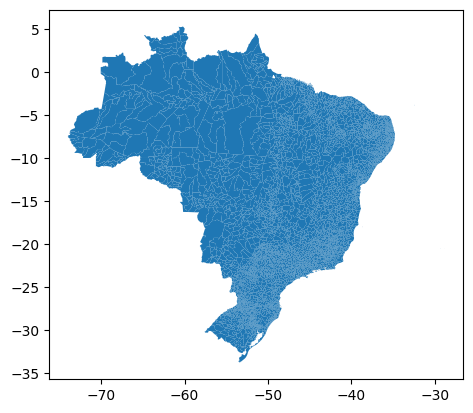

In [21]:
# mapa mais simples: função plot()
br.plot();

In [22]:
br.columns

Index(['mun', 'geometry', 'nome_mun', 'sigla_uf', 'nome_regiao', 'nome_meso',
       'nome_micro', 'algodao', 'arroz', 'banana', 'cafe', 'cana', 'feijao',
       'fumo', 'laranja', 'mandioca', 'milho', 'soja', 'tomate'],
      dtype='object')

Vamos criar uma variável chamada "variavel" para salvar qual queremos analisar. Se for necessário alterar qual queremos analisar, basta voltar nessa célula e escolher outra:

In [23]:
variavel = 'soja'

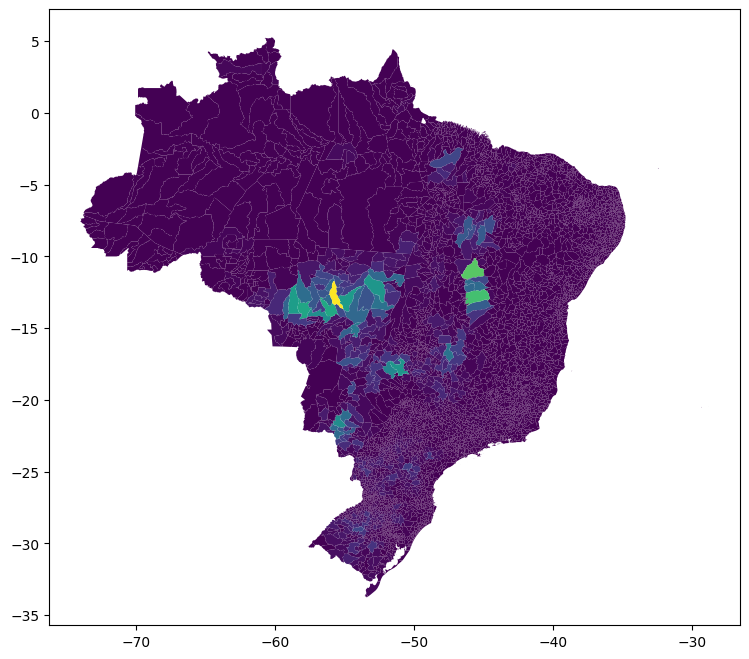

In [24]:
# mapa temático - simples
br.plot(variavel, figsize=(12, 8));

# Escolher um recorte do mapa

Para facilitar a visualização dos dados, vamos escolher uma região (estado, região, microrregião etc.) e analisar apenas essa parte.

In [46]:
df = br.query("sigla_uf == 'MG'")

In [47]:
df

,mun,geometry,nome_mun,sigla_uf,nome_regiao,nome_meso,nome_micro,algodao,arroz,banana,cafe,cana,feijao,fumo,laranja,mandioca,milho,soja,tomate
2243,3100104,"POLYGON ((-47.4384 -18.1657, -47.42637 -18.170...",Abadia dos Dourados,MG,Sudeste,Triângulo Mineiro/Alto Paranaíba,Patrocínio,0,2,90,144,457,2,0,0,260,8016,11286,100
2244,3100203,"POLYGON ((-45.16777 -18.89073, -45.14029 -18.8...",Abaeté,MG,Sudeste,Central Mineira,Três Marias,0,8,50,180,9500,0,0,0,280,6259,1740,0
2245,3100302,"POLYGON ((-42.38219 -20.12176, -42.36801 -20.1...",Abre Campo,MG,Sudeste,Zona da Mata,Manhuaçu,0,8,80,4200,9000,294,0,0,110,1200,0,0
2246,3100401,"POLYGON ((-43.13156 -20.34249, -43.10879 -20.3...",Acaiaca,MG,Sudeste,Zona da Mata,Ponte Nova,0,0,60,4,1400,29,0,5,20,276,0,0
2247,3100500,"POLYGON ((-42.37085 -18.92507, -42.36208 -18.9...",Açucena,MG,Sudeste,Vale do Rio Doce,Ipatinga,0,1,180,5,3000,112,0,0,32,825,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,3171808,"POLYGON ((-42.70275 -18.66162, -42.66066 -18.6...",Virginópolis,MG,Sudeste,Vale do Rio Doce,Guanhães,0,2,238,123,6500,86,0,0,66,750,0,2280
3092,3171907,"POLYGON ((-42.3218 -18.35685, -42.32659 -18.36...",Virgolândia,MG,Sudeste,Vale do Rio Doce,Governador Valadares,0,2,175,86,1200,69,0,15,30,240,0,0
3093,3172004,"POLYGON ((-42.9061 -20.93325, -42.88458 -20.93...",Visconde do Rio Branco,MG,Sudeste,Zona da Mata,Ubá,0,0,315,5,18300,48,0,2600,80,252,0,250
3094,3172103,"POLYGON ((-42.57184 -21.68033, -42.55891 -21.6...",Volta Grande,MG,Sudeste,Zona da Mata,Cataguases,0,0,180,0,60,6,0,50,270,7,0,0


In [48]:
df = df.reset_index()
df

,index,mun,geometry,nome_mun,sigla_uf,nome_regiao,nome_meso,nome_micro,algodao,arroz,banana,cafe,cana,feijao,fumo,laranja,mandioca,milho,soja,tomate
0,2243,3100104,"POLYGON ((-47.4384 -18.1657, -47.42637 -18.170...",Abadia dos Dourados,MG,Sudeste,Triângulo Mineiro/Alto Paranaíba,Patrocínio,0,2,90,144,457,2,0,0,260,8016,11286,100
1,2244,3100203,"POLYGON ((-45.16777 -18.89073, -45.14029 -18.8...",Abaeté,MG,Sudeste,Central Mineira,Três Marias,0,8,50,180,9500,0,0,0,280,6259,1740,0
2,2245,3100302,"POLYGON ((-42.38219 -20.12176, -42.36801 -20.1...",Abre Campo,MG,Sudeste,Zona da Mata,Manhuaçu,0,8,80,4200,9000,294,0,0,110,1200,0,0
3,2246,3100401,"POLYGON ((-43.13156 -20.34249, -43.10879 -20.3...",Acaiaca,MG,Sudeste,Zona da Mata,Ponte Nova,0,0,60,4,1400,29,0,5,20,276,0,0
4,2247,3100500,"POLYGON ((-42.37085 -18.92507, -42.36208 -18.9...",Açucena,MG,Sudeste,Vale do Rio Doce,Ipatinga,0,1,180,5,3000,112,0,0,32,825,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,3091,3171808,"POLYGON ((-42.70275 -18.66162, -42.66066 -18.6...",Virginópolis,MG,Sudeste,Vale do Rio Doce,Guanhães,0,2,238,123,6500,86,0,0,66,750,0,2280
849,3092,3171907,"POLYGON ((-42.3218 -18.35685, -42.32659 -18.36...",Virgolândia,MG,Sudeste,Vale do Rio Doce,Governador Valadares,0,2,175,86,1200,69,0,15,30,240,0,0
850,3093,3172004,"POLYGON ((-42.9061 -20.93325, -42.88458 -20.93...",Visconde do Rio Branco,MG,Sudeste,Zona da Mata,Ubá,0,0,315,5,18300,48,0,2600,80,252,0,250
851,3094,3172103,"POLYGON ((-42.57184 -21.68033, -42.55891 -21.6...",Volta Grande,MG,Sudeste,Zona da Mata,Cataguases,0,0,180,0,60,6,0,50,270,7,0,0


In [49]:
# média
df[variavel].mean()

np.float64(6375.282532239156)

In [50]:
# retornar em ordem decrescente de produção
df.sort_values(variavel, ascending=False).head(5)

,index,mun,geometry,nome_mun,sigla_uf,nome_regiao,nome_meso,nome_micro,algodao,arroz,banana,cafe,cana,feijao,fumo,laranja,mandioca,milho,soja,tomate
825,3068,3170404,"POLYGON ((-46.63338 -15.79167, -46.61244 -15.8...",Unaí,MG,Sudeste,Noroeste de Minas,Unaí,19632,0,2900,11214,2284500,63870,0,0,1440,380400,422400,540
100,2343,3109303,"POLYGON ((-46.62806 -15.08949, -46.57531 -15.0...",Buritis,MG,Sudeste,Noroeste de Minas,Unaí,4895,30,175,720,3300,20700,0,5600,700,168000,357000,30
549,2792,3147006,"POLYGON ((-47.01726 -16.59694, -46.99942 -16.6...",Paracatu,MG,Sudeste,Noroeste de Minas,Paracatu,3393,470,350,4500,2186800,54920,0,54,2550,227280,351000,0
822,3065,3170107,"POLYGON ((-47.86496 -19.08313, -47.84887 -19.1...",Uberaba,MG,Sudeste,Triângulo Mineiro/Alto Paranaíba,Uberaba,0,0,450,1065,6800000,4904,0,13650,5100,252000,244200,390
324,2567,3128600,"POLYGON ((-46.90191 -17.46619, -46.86705 -17.4...",Guarda-Mor,MG,Sudeste,Noroeste de Minas,Paracatu,0,6,1210,713,150,22500,0,0,1280,125400,230100,0


# Mapas temáticos

Um mapa temático (*choropleth map*) é usado para representar os valores da variável em estudo por meio de classes e cores. O mapa é dividido em classes que são coloridas de acordo com os valores da variável. Os tipos mais comuns de mapas temáticos são:

- intervalos iguais: divide a amplitude de valores em intervalos iguais. Útil para dados com distribuição uniforme. O número de observações em cada classe pode ficar muito desigual;

- quantis: atribui-se a mesma quantidade de valores para cada categoria (de acordo com o número de quantis definidos). Útil para reduzir o impacto de *outliers* nos dados;

- Fisher Jenks: procura agrupamentos naturais baseando-se na distribuição dos dados (tenta reduzir a variância dos valores dentro de cada classe e maximizar a variância entre as classes). Útil para dados muito assimétricos. O número de observações em cada classe pode ser desigual.

Na função *plot* escolher: scheme='equal_interval', 'quantiles' ou 'fisher_jenks'.

Esquemas de cores: cmap (https://matplotlib.org/stable/tutorials/colors/colormaps.html)

Opções: PuBu, GnBu, Oranges, BuGn, Purples, YlOrBr


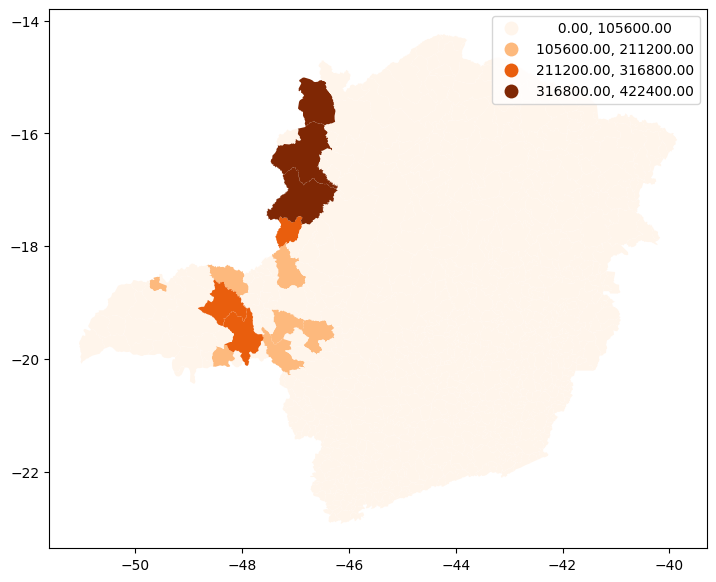

In [51]:
# equal_interval
df.plot(column=variavel, figsize=(10, 7), scheme='equal_interval', legend=True, k=4, cmap='Oranges');

Análise:

Para a cultura da soja, que é distribuída de forma não uniforme no estado de SP, esse tipo de mapa não ajuda a visualizar a distribuição dos valores. Ele acaba chamando muita atenção para os *outliers* (produção muito alta). Ele poderia ser útil para uma cultura com distribuição mais equilibrada de valores.


Para o mapa de quantis eu escolhi k=4, ou seja, para coincidir com os quartis da distribuição (Q1, Q2 e Q3).

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1760: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


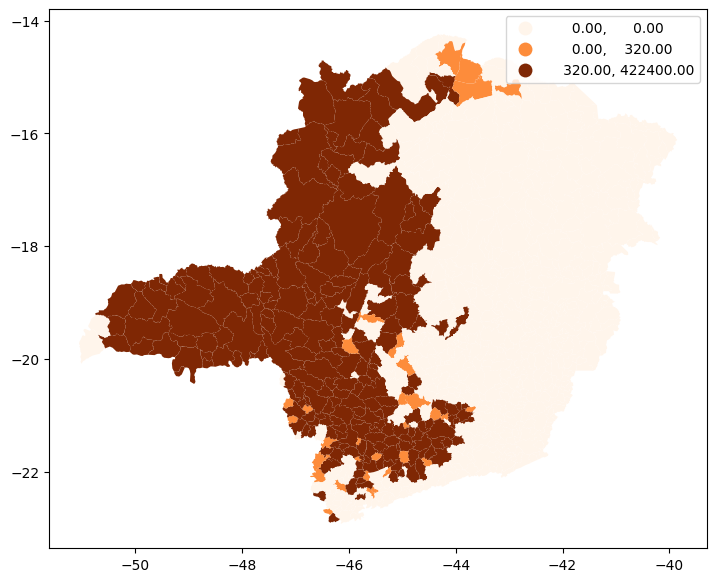

In [52]:
# quantiles
df.plot(column=variavel, figsize=(10, 7), scheme='quantiles', legend=True, k=4, cmap='Oranges');

Análise:

A distribuição de soja parece estar concentrada nas porções sul e norte do estado de SP. O litoral apresenta produção muito baixa, com a maior parte dos valores 0 de produção.

Em média, o estado produziu 5.312 toneladas de soja. Os quartis da produção de soja são: Q1 - 0 ton, Q2 - 360 ton e Q3 - 2.509 ton. Dessa forma, 25% dos municípios de SP não produziram soja e 75% deles produziram, pelo menos, 360 toneladas. O valor máximo produzido foi de 341.400 toneladas no município de Itapeva.



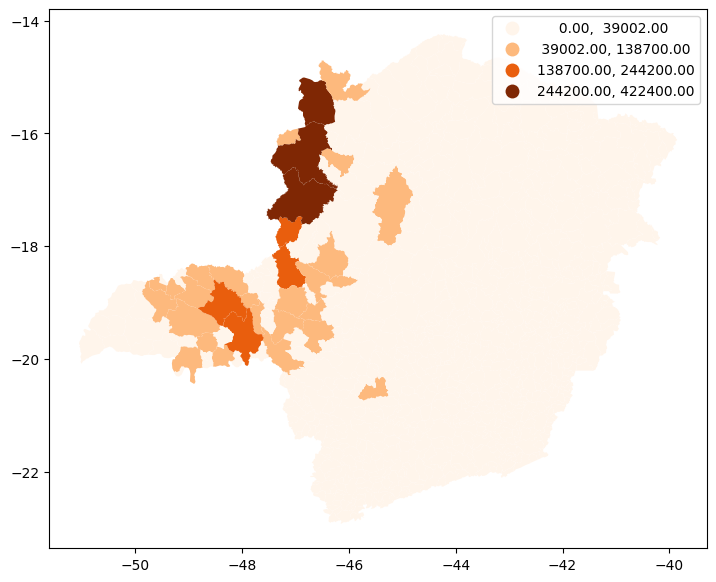

In [53]:
# fisher_jenks
df.plot(column=variavel, figsize=(10, 7), scheme='fisher_jenks', legend=True, k=4, cmap='Oranges');

Análise:

De acordo com esse mapa, a distribuição dos intervalos ficou mais equilibrada, porém, a concentração de maiores produções não ficou tão evidente quanto o mapa de quantis. Ainda assim, é possível ver como as regiões norte e sul do estado concentram a maior parte da produção de soja.



In [54]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(df)
w.transform = 'r'

/tmp/ipython-input-54-2647982255.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(df)


Há uma ilha que está impedindo a obtenção da matriz de vizinhos **W**, vamos descobrir quem é:

In [55]:
df.iloc[231]['nome_mun']

'Curvelo'

In [56]:
df = df.drop([231]) # retirar ilhas se houver

In [57]:
# obter matriz de vizinhança no formato queen

w = Queen.from_dataframe(df)
w.transform = 'r'

/tmp/ipython-input-57-2725344876.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(df)


# I de Moran

Estatística mais utilizada para medir a autocorrelação espacial. Ela mede a relação do desvio padronizado de uma variável numa área com o desvio padronizado das áreas vizinhas para a mesma variável:

$$I=\frac{N}{S_{0}}\frac{\displaystyle\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}z_{i}z_{j}}{\displaystyle\sum_{i=1}^{n}z^{2}_{i}},$$
em que:

- $z_i = y_i - \bar{y}$ representa o desvio em relação à média da variável.
- $y_i$: valor da variável em um determinado local $i$
- $N$: número de observações
- $S_0 = \sum\sum w_{ij}$
- $E[I] = -1/(N - 1) \approx 0$
            
Se o valor-$p$ referente ao teste do $I$ de Moran for significativo, podemos olhar para o valor da estatística $I$ e concluir:

- $I > 0$: autocorrelação espacial positiva (*clusters* espaciais - HH, LL)
- $I < 0$: autocorrelação espacial negativa (*outliers* espaciais - HL, LH)

In [58]:
# calcular I de Moran global para a variável escolhida
y = df[variavel].values
moran = Moran(y, w)
moran.I

np.float64(0.5304483106580684)

In [59]:
# valor-p
moran.p_sim

np.float64(0.001)

Como o valor-p foi menor do que 0,05, conclui-se que o valor do I de Moran é significativo. Assim, rejeita-se $H_0$ de aleatoriedade espacial. Há autocorrelação espacial e ela é positiva, sendo assim, há tendência de *clusters* espaciais (AA e BB).

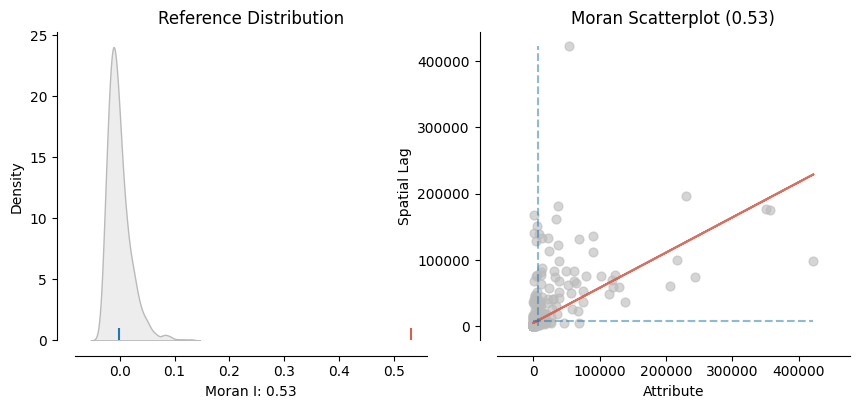

In [60]:
# diagrama de dispersão de Moran
plot_moran(moran, zstandard=False, figsize=(10,4));

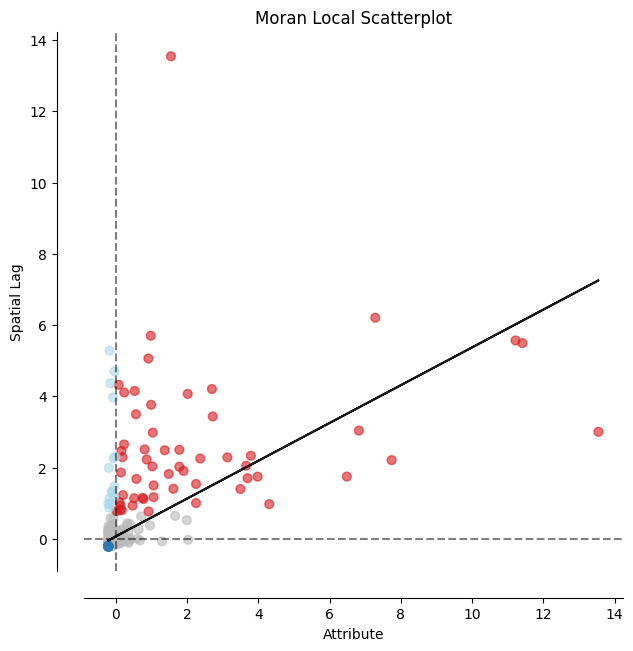

In [61]:
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

### LISA

- Estatística para detectar padrões locais de autocorrelação espacial: *Local Indicator of Spatial Association* (LISA), ou $I$ de Moran local  
- Permite verificar se há agrupamentos espaciais estatisticamente significativos
- Útil quando a estatística $I$ de Moran global for significativa

$$I_{i}=z_{i}\sum_{j=1}^{j}w_{ij}y_{j}$$  

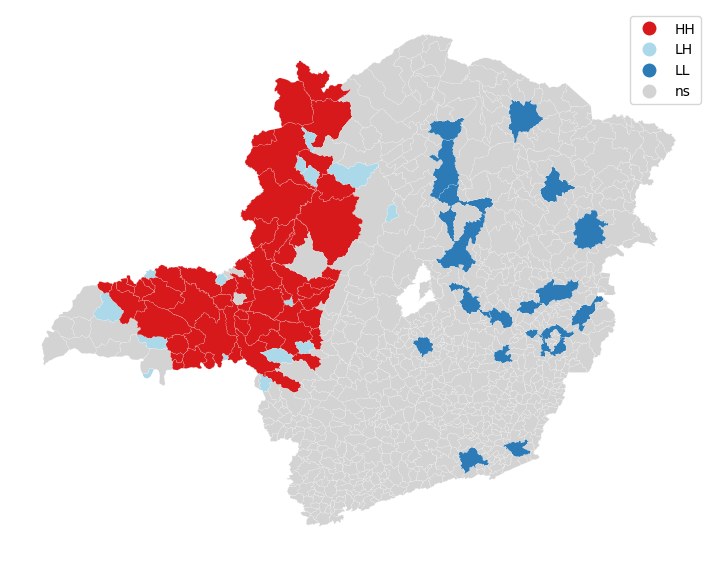

In [62]:
lisa_cluster(moran_loc, df, p=0.05, figsize = (9,9));

A concentração de *clusters* do tipo AA está no sul e no norte do estado. Porém, o sul concentra ainda mais esses municípios de grande produção rodeados por municípios também de grande produção. No litoral (leste do estado) estão os pontos BB. Há alguns *outliers* espaciais do tipo BA próximos aos *clusters* AA, principalmente no sul do estado.  

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1760: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


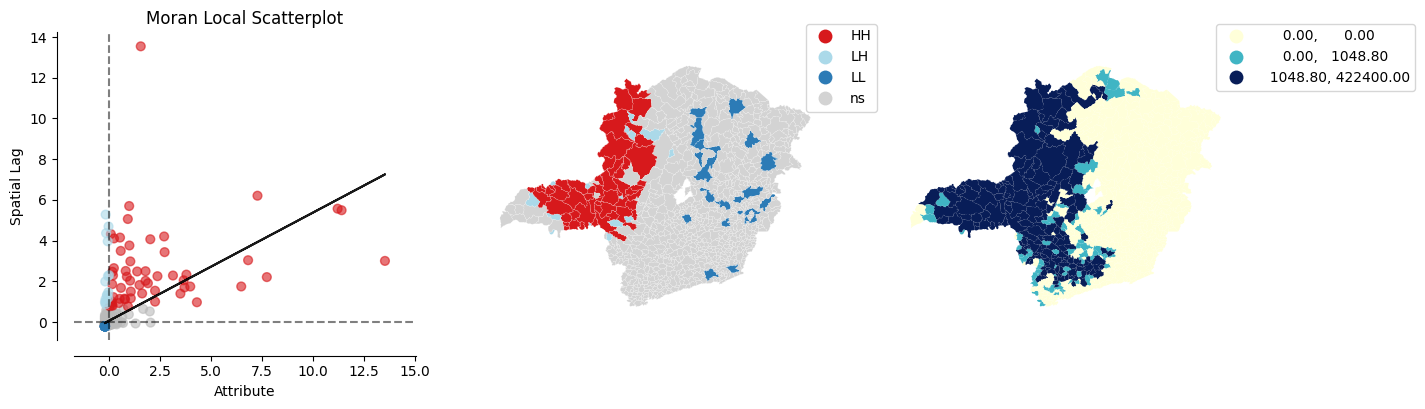

In [63]:
plot_local_autocorrelation(moran_loc, df, variavel);

Bônus: mapa interativo com o pacote *folium*

In [64]:
# Install Folium for Geographic data visualization
!pip install folium

In [65]:
import folium

In [66]:
m = folium.Map (location = [-21.57211213097603, -45.42873654009771])
m